## Đồ Án Môn Neural 
### Đề tài: Phân loại tập dữ liệu X-Gray
### Nguyễn Vương Triều An - 2001190019
### Huỳnh Thanh Thiện - 2001181333
### Lâm Nguyễn Hào - 2001190079



In [ ]:
# Import thư viện cần thiết
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:

# define paths

train_normal_dir = '/content/drive/MyDrive/Data/chest_xray/train/NORMAL/'
train_pneu_dir ='/content/drive/MyDrive/Data/chest_xray/train/PNEUMONIA/'

test_normal_dir = '/content/drive/MyDrive/Data/chest_xray/test/NORMAL/'
test_pneu_dir =  '/content/drive/MyDrive/Data/chest_xray/test/PNEUMONIA/'

val_normal_dir = '/content/drive/MyDrive/Data/chest_xray/val/NORMAL/'
val_pneu_dir =  '/content/drive/MyDrive/Data/chest_xray/val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


In [ ]:
# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# tạo danh sách cho các trường hợp , kiểm tra và xác nhận, tạo nhãn 
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# xáo trộn / ngẫu nhiên hóa dữ liệu khi chúng được tải theo thứ tự: trường hợp bình thường, sau đó là trường hợp viêm phổi
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

# gắn lable và trực quan hóa biểu đò


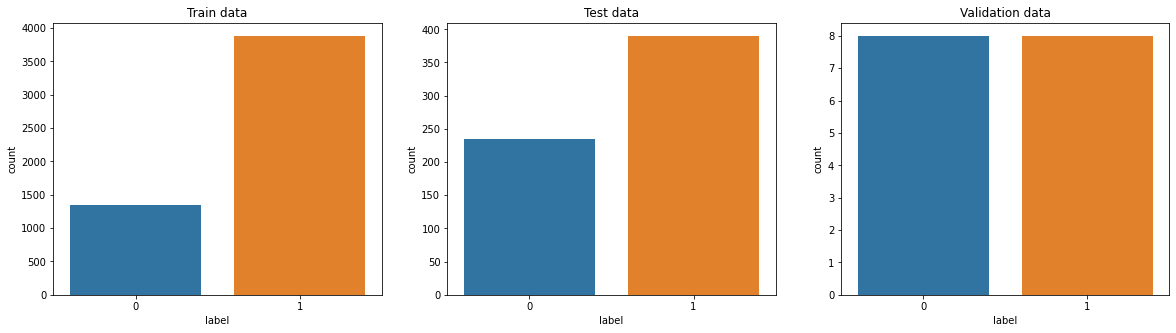

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()

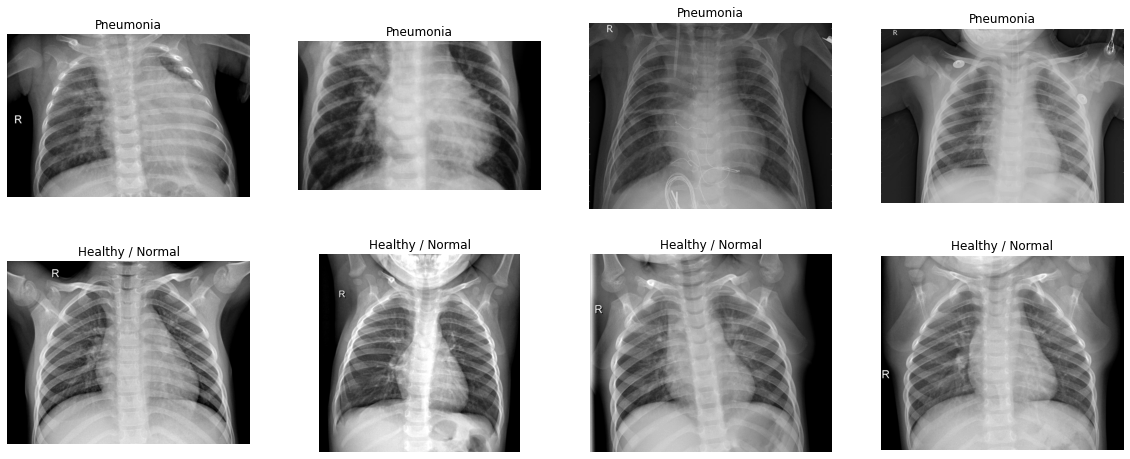

In [ ]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Healthy / Normal')

In [ ]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [ ]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5232, 196, 196, 1), Labels shape: (5232,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


In [ ]:
# tăng cường dữ liệu bằng cách xoay ảnh
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
model = Sequential() #cnn

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)
history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 25, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})

Epoch 1/25
1308/1308 [==============================] - 652s 497ms/step - loss: 0.6316 - accuracy: 0.5566 - val_loss: 0.4321 - val_accuracy: 0.8029
Epoch 2/25
1308/1308 [==============================] - 654s 500ms/step - loss: 0.3542 - accuracy: 0.8112 - val_loss: 0.3012 - val_accuracy: 0.8734
Epoch 3/25
1308/1308 [==============================] - 663s 507ms/step - loss: 0.2908 - accuracy: 0.8603 - val_loss: 0.3396 - val_accuracy: 0.8750
Epoch 4/25
1308/1308 [==============================] - 668s 510ms/step - loss: 0.2389 - accuracy: 0.8872 - val_loss: 0.3123 - val_accuracy: 0.8766
Epoch 5/25
1308/1308 [==============================] - 666s 509ms/step - loss: 0.2273 - accuracy: 0.8907 - val_loss: 0.2725 - val_accuracy: 0.8878
Epoch 6/25
1308/1308 [==============================] - 653s 499ms/step - loss: 0.1928 - accuracy: 0.9069 - val_loss: 0.3371 - val_accuracy: 0.8910
Epoch 7/25
1308/1308 [==============================] - 643s 492ms/step - loss: 0.1995 - accuracy: 0.9062 - val_

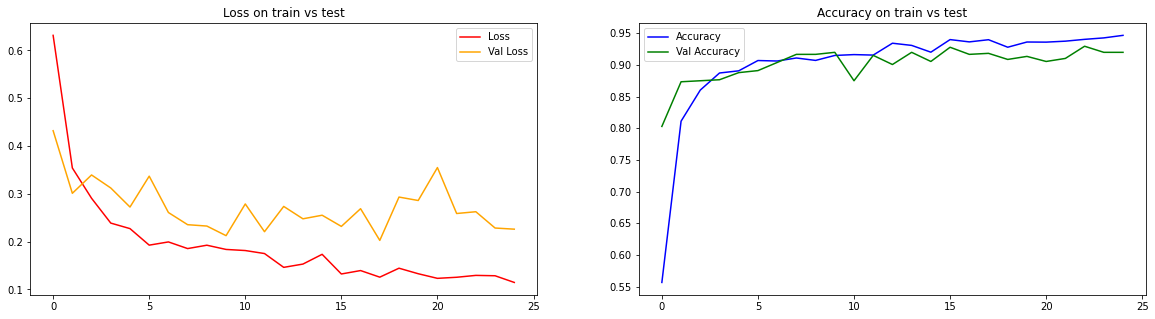

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

In [ ]:
#dự đoán
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

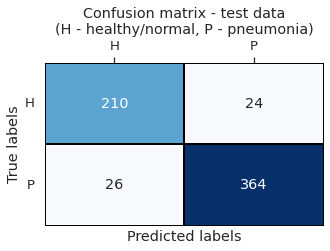

Classification report on test data
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       234
           1       0.94      0.93      0.94       390

    accuracy                           0.92       624
   macro avg       0.91      0.92      0.91       624
weighted avg       0.92      0.92      0.92       624



In [ ]:
# tính toán ma trận  và báo cáo phân loại
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# ma trận dươi dạng bản đò nhiệt
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

#in phân loại báo cáo
print('Classification report on test data')
print(clas_r)

In [ ]:
y_val_hat = model.predict(X_val, batch_size=4)
y_val_hat = np.argmax(y_val_hat, axis=1)
y_val = np.argmax(y_val, axis=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


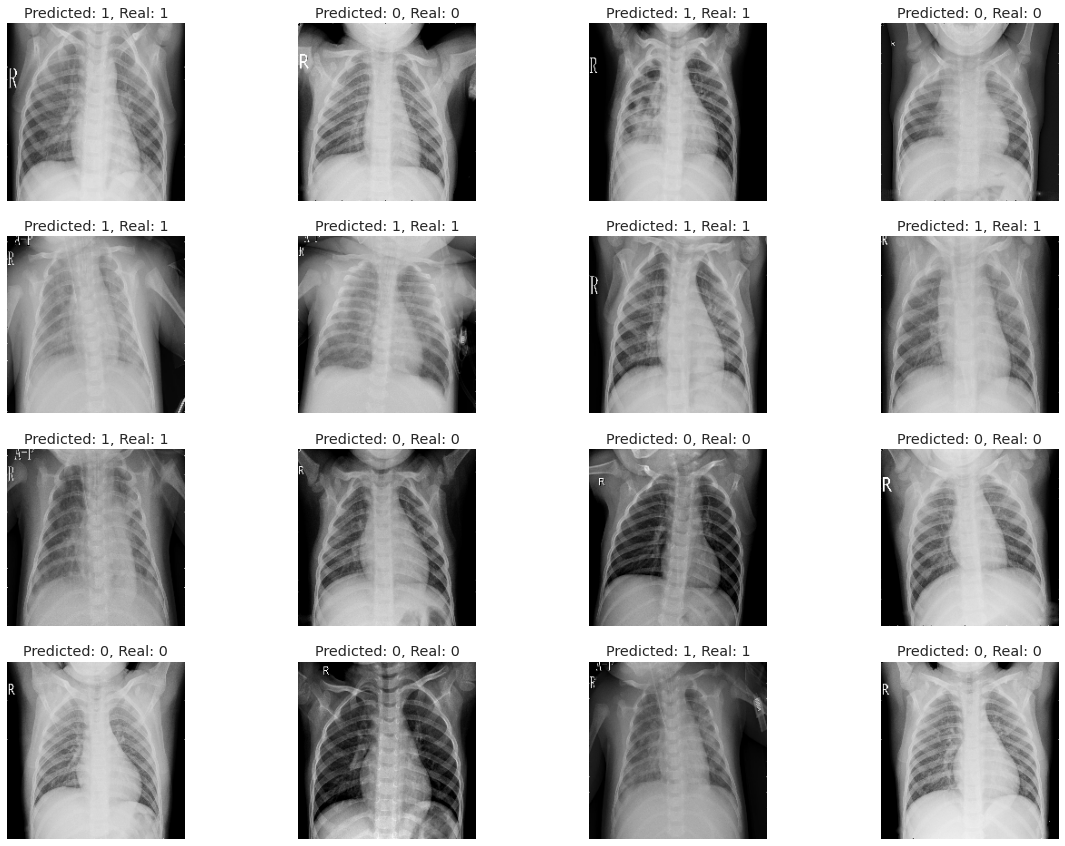

In [ ]:
plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(196, 196), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i])) 

## Lưu model

In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model.save('/content/drive/MyDrive/Data/X-Gray.h5')